In [33]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
con = sqlite3.connect("../unified_CD2.db")
cur = con.cursor()
df = pd.read_sql_query("SELECT * FROM prod_desc", con)

df['AB'] = df['AB'].apply(lambda x: int.from_bytes(x, 'little'))# converting binary to dec int

In [35]:
descriptors = df.columns[9:]
unidescriptors = [d for d in descriptors if len(df[d].unique()) < 2]# checking which descriptors have singular entries
print('len desc, len unidesc', len(descriptors), len(unidescriptors))
print(df.shape)
df.drop(unidescriptors, axis = 1, inplace = True)# dropping descriptors with singular value for all samples
print(df.shape)

len desc, len unidesc 210 69
(12801, 219)
(12801, 150)


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import time

## initially tried with non scaled descriptors

In [37]:
X = df.iloc[:, 9:]
X.shape
y = df['AB']
print(X.shape, y.shape)

(12801, 141) (12801,)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=0)
print(y_train.value_counts())# check that training with AB = 0&!1

1    4845
0    4115
Name: AB, dtype: int64


In [ ]:
K = []
training = []
test = []
ts = []
# scores = {}

for k in range(2, 10):
    print('running k= ', k)
    t0 = time.time()
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
    ts.append(time.time()-t0)

    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    K.append(k)
    training.append(training_score)
    test.append(test_score)
    #scores[k] = [training_score, test_score]

running k=  2
running k=  3
running k=  4
running k=  5
running k=  6
running k=  7
running k=  8
running k=  9


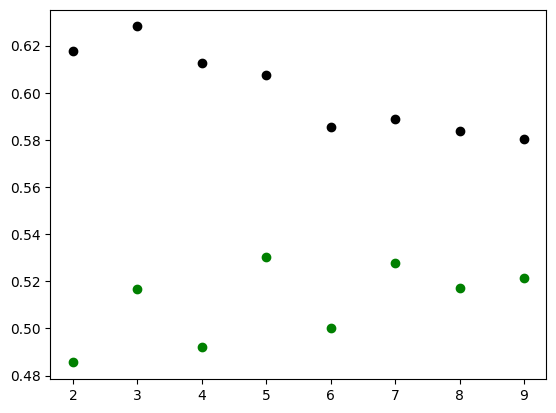

In [ ]:
# choosing best K
plt.scatter(K, training, color ='k')
plt.scatter(K, test, color ='g')
plt.show()

## trying with normalisation and pca of descriptors



In [39]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [40]:
ndescriptors = [d for d in X.columns if len(X[d].value_counts() ) > 1000]
# assuming this is sufficient requirement to identify non categorical descriptors
print(ndescriptors)

['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA2', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SlogP_VSA1', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA5', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA8', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_ESt

In [41]:
dfn = df.copy()# already discarded noninforming descriptors before
dfn[ndescriptors] = normalize(dfn[ndescriptors], norm = 'l2')
df.shape, dfn.shape

((12801, 150), (12801, 150))

In [42]:
X = dfn.iloc[:, 9:]
X.shape
y = dfn['AB']
print(X.shape, y.shape)

(12801, 141) (12801,)


In [43]:
pca = PCA(n_components = 0.99)# can already retain over 0.8 of variance with one descriptor
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
Xpca = pca.transform(X)

[0.89323951 0.03769263 0.03231509 0.01381121 0.00612537 0.00447824
 0.00375534]
[31720.71335956  6516.09161981  6033.39408825  3944.34418206
  2626.78940482  2246.0146149   2056.75872574]


In [68]:
list(most_important_names[0].values)

['PEOE_VSA10', 'PEOE_VSA12', 'HeavyAtomCount']

In [77]:
# taken from: https://stackoverflow.com/questions/47370795/pca-on-sklearn-how-to-interpret-pca-components
pca.components_.shape# 7, 141
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.argpartition(np.abs(pca.components_[i]), -3)[-3:] for i in range(n_pcs)]

initial_feature_names = dfn.columns[9:]
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {f'PC{i}': most_important_names[i].values for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())
df.columns = ['PC', 'Descriptors']
df[['3', '2', '1']] = pd.DataFrame(df.Descriptors.tolist(), index= df.index)
df.drop('Descriptors', axis=1, inplace=True)

df

,PC,3,2,1
0,PC0,PEOE_VSA10,PEOE_VSA12,HeavyAtomCount
1,PC1,SlogP_VSA12,EState_VSA11,SlogP_VSA6
2,PC2,SMR_VSA4,PEOE_VSA4,SlogP_VSA12
3,PC3,PEOE_VSA11,EState_VSA9,EState_VSA11
4,PC4,SlogP_VSA4,EState_VSA9,EState_VSA11
5,PC5,SMR_VSA4,SlogP_VSA4,PEOE_VSA14
6,PC6,PEOE_VSA14,EState_VSA11,EState_VSA7


In [16]:
X_train, X_test, y_train, y_test = train_test_split(Xpca, y, test_size = 0.30, random_state=0)
print(y_train.value_counts())


1    4845
0    4115
Name: AB, dtype: int64


In [ ]:
K = []
training = []
test = []
ts = []
# scores = {}

for k in range(2, 21):
    print('running k= ', k)
    t0 = time.time()
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
    ts.append(time.time()-t0)

    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    K.append(k)
    training.append(training_score)
    test.append(test_score)

running k=  2
running k=  3
running k=  4
running k=  5
running k=  6
running k=  7
running k=  8
running k=  9
running k=  10
running k=  11
running k=  12
running k=  13
running k=  14
running k=  15
running k=  16
running k=  17
running k=  18
running k=  19
running k=  20


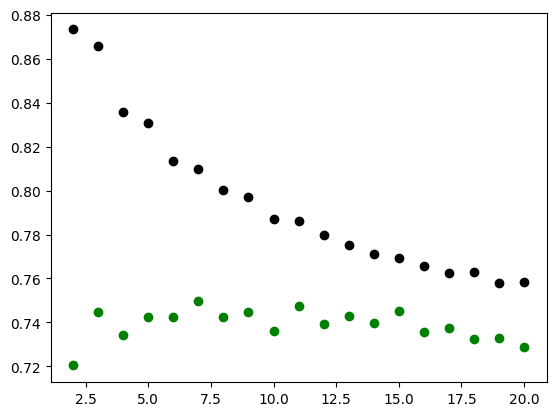

In [ ]:
plt.scatter(K, training, color ='k')
plt.scatter(K, test, color ='g')
plt.show()

# plots

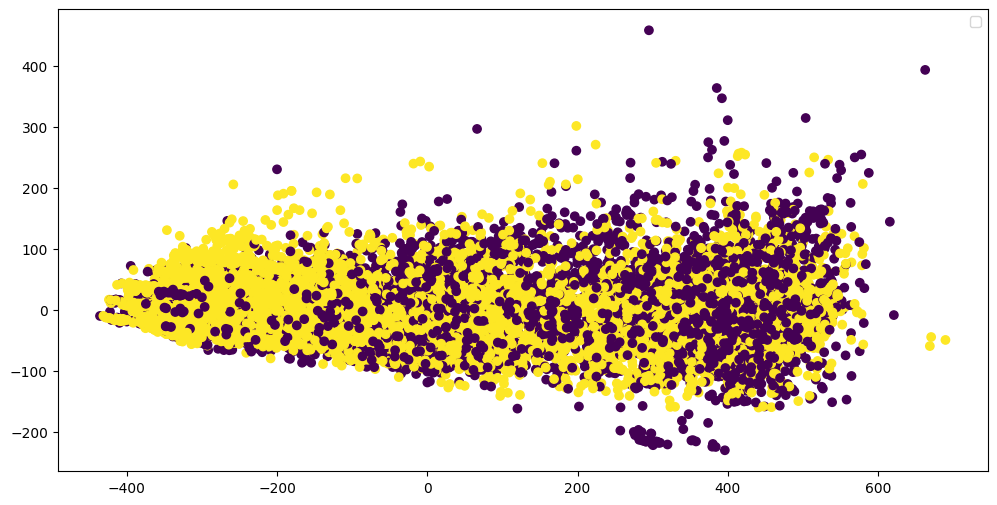

In [ ]:
# first two dimensions of pca

fig, ax = plt.subplots(figsize = (12, 6))
ax.scatter(Xpca[:, 0], Xpca[:, 1], c = y[:].values)
plt.legend()

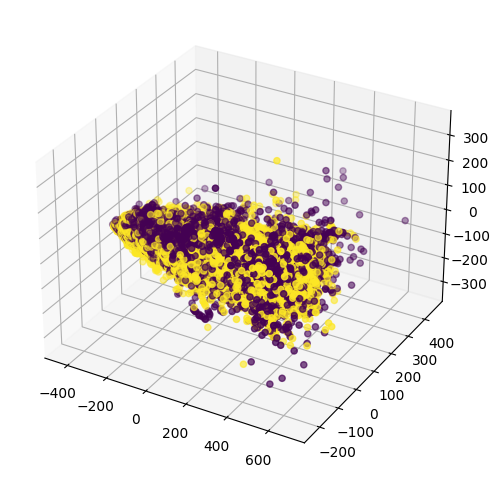

In [ ]:
# first three dimensions of pca

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xpca[:, 0], Xpca[:, 1], Xpca[:, 2], c = y[:].values)

In [ ]:
groupex = dfn.groupby(['source'])['source'].apply(lambda x: x.index[0])# example point per group, for labeling purposes
groupex

source
APD_sequence_release_09142020.fasta      92
BAAMPs_data.csv                        8158
DADP.html                               814
HIPdb_data.xls                         1096
InverPep.fasta                            0
LAMP2.fasta                             227
dbaasp_ribosomal.txt                   1086
dramp_antimicrobial.fasta              2100
uniprot_swissprot.fasta                   1
Name: source, dtype: int64

In [ ]:
for n, i in zip(groupex.index, groupex.values):
  print(i, n)

92 APD_sequence_release_09142020.fasta
8158 BAAMPs_data.csv
814 DADP.html
1096 HIPdb_data.xls
0 InverPep.fasta
227 LAMP2.fasta
1086 dbaasp_ribosomal.txt
2100 dramp_antimicrobial.fasta
1 uniprot_swissprot.fasta


In [ ]:
ls = [i for i in groupex.values]
[i for i in groupex.index]

['APD_sequence_release_09142020.fasta',
 'BAAMPs_data.csv',
 'DADP.html',
 'HIPdb_data.xls',
 'InverPep.fasta',
 'LAMP2.fasta',
 'dbaasp_ribosomal.txt',
 'dramp_antimicrobial.fasta',
 'uniprot_swissprot.fasta']

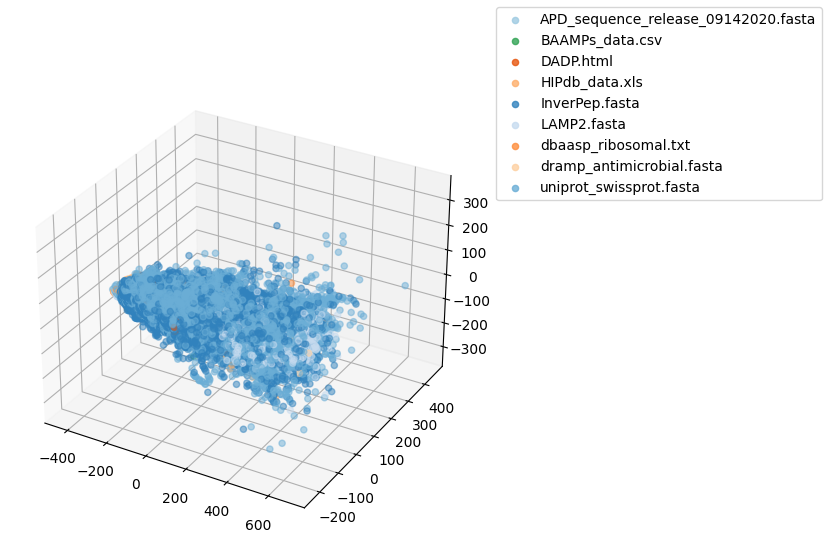

In [ ]:
"""
dcols = {n:i for i, n in enumerate( dfn['source'].unique() )}
lcols = [dcols[s] for s in dfn['source'].values]
llabels = [n for n in dfn['source'].values]

for x,y,z,c,l in zip(Xpca[:, 0], Xpca[:, 1], Xpca[:, 2], lcols,llabels):
    ax.scatter(x, y, z, c=c,label=l)

"""

dcols = {n:i for i, n in enumerate( dfn['source'].unique() )}
import matplotlib as mpl
viridis = mpl.colormaps['tab20c']#(range(len(dcols)) )#.resampled(len(dcols))
lcols = [viridis(dcols[s]) for s in dfn['source'].values]


fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, projection='3d')

for n, i in zip(groupex.index, groupex.values):
  #print(n, i, lcols[i])
  ax.scatter(Xpca[i, 0], Xpca[i, 1], Xpca[i, 2], color = lcols[i], alpha = 0.8, label = n)

ax.scatter(Xpca[:, 0], Xpca[:, 1], Xpca[:, 2], c = lcols, alpha = 0.5)

fig.legend()



# Kfold CV

In [12]:
from sklearn.model_selection import KFold

In [17]:
Xpca.shape

(12801, 7)

In [ ]:
kf = KFold(n_splits=10)

outputs = {}
i = 0
for train, test in kf.split(Xpca):
  print(i)
  training = []
  testing = []
  K = []
  ts = []

  X_train = Xpca[train, :]
  X_test = Xpca[test, :]
  y_train = y[train]
  y_test = y[test]
  print( X_train.shape, X_test.shape, y_train.shape, y_test.shape )

  for k in range(2, 21):
      print('running k= ', k)
      t0 = time.time()
      clf = KNeighborsClassifier(n_neighbors = k)
      clf.fit(X_train, y_train)
      ts.append(time.time()-t0)

      training_score = clf.score(X_train, y_train)
      test_score = clf.score(X_test, y_test)

      K.append(k)
      training.append(training_score)
      testing.append(test_score)
  outputs[i] = (K, training, testing)
  i+=1



0
(11520, 7) (1281, 7) (11520,) (1281,)
running k=  2
running k=  3
running k=  4
running k=  5
running k=  6
running k=  7
running k=  8
running k=  9
running k=  10
running k=  11
running k=  12
running k=  13
running k=  14
running k=  15
running k=  16
running k=  17
running k=  18
running k=  19
running k=  20
1
(11521, 7) (1280, 7) (11521,) (1280,)
running k=  2
running k=  3
running k=  4
running k=  5
running k=  6
running k=  7
running k=  8
running k=  9
running k=  10
running k=  11
running k=  12
running k=  13
running k=  14
running k=  15
running k=  16
running k=  17
running k=  18
running k=  19
running k=  20
2
(11521, 7) (1280, 7) (11521,) (1280,)
running k=  2
running k=  3
running k=  4
running k=  5
running k=  6
running k=  7
running k=  8
running k=  9
running k=  10
running k=  11
running k=  12
running k=  13
running k=  14
running k=  15
running k=  16
running k=  17
running k=  18
running k=  19
running k=  20
3
(11521, 7) (1280, 7) (11521,) (1280,)
running k

In [ ]:
nKs = 19
folds = 10

meantraining = np.zeros((nKs, folds))
meantesting = np.zeros((nKs, folds))
Ks = np.zeros((nKs, folds))

for f in outputs.keys():# for each fold
  K, tr, te = outputs[f]
  meantraining[:, f] = tr
  meantesting [:, f] = te
  Ks [:, f] = K

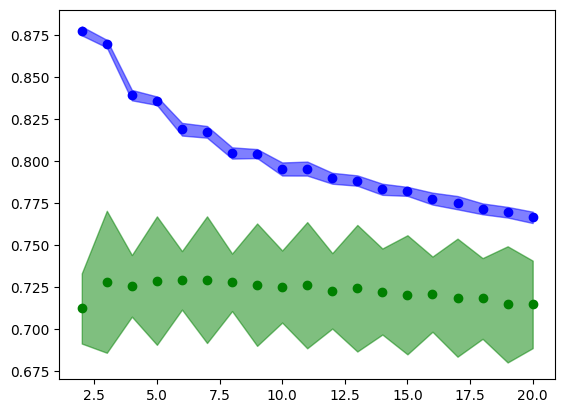

In [ ]:
fig, ax = plt.subplots()

#Ks = np.mean(Ks, axis = 1)

trainsd = np.std(meantraining, axis = 1)
trainmean = np.mean(meantraining, axis = 1)
ax.scatter(Ks, trainmean, color = 'b', label = 'train')
ax.fill_between(Ks, trainmean-trainsd, trainmean+trainsd, alpha = 0.5, color = 'b')

testsd = np.std(meantesting, axis = 1)
testmean = np.mean(meantesting, axis = 1)
ax.scatter(Ks, testmean, color = 'g', label = 'test')
ax.fill_between(Ks, testmean-testsd, testmean+testsd, alpha = 0.5, color = 'g')

fig.legend()



## go with k = 2

In [18]:
X_train, X_test, y_train, y_test = train_test_split(Xpca, y, test_size = 0.30, random_state=0)

In [20]:
k = 6
t0 = time.time()
clf = KNeighborsClassifier(n_neighbors = k)
clf.fit(X_train, y_train)
t1 = (time.time()-t0)

training_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(t1, training_score, test_score)


0.016498088836669922 0.8133928571428571 0.7425149700598802


auc:  0.8137070341700369


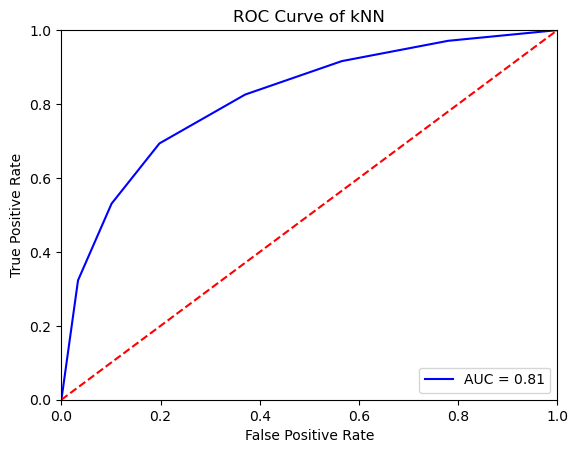

In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_scores = clf.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
print('auc: ', roc_auc)

plt.title('Receiver Operating Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [22]:
y_pred = clf.predict(X_test)
y_pred


array([1, 0, 0, ..., 1, 1, 1])

In [23]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

0.8106312292358804

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7425149700598802

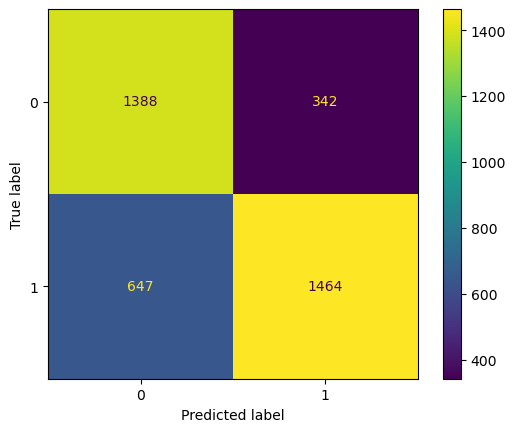

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()